In [1]:
import tensorflow as tf, matplotlib.pyplot as plt, os, numpy as np, matplotlib.pyplot as plt, matplotlib.patches as patches
from sklearn.metrics import confusion_matrix as C_M, accuracy_score as A_S, classification_report as C_R
from object_detection.utils import label_map_util as LMU

# Read Dataset from TFRecord

In [2]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
IMAGE_SIZE = [512, 512]  # make sure had same size with the picture

In [3]:
def decode_image(img):
    img = tf.cast(img, tf.int32)
    return img

In [4]:
def read_tfrecord(example):
    tfrecord_format = {
        "filename": tf.io.FixedLenFeature([], tf.string),
        "pic": tf.io.FixedLenFeature([], tf.string),
        "bbox": tf.io.FixedLenFeature([], tf.string),
        "label": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    filename = tf.cast(example["filename"], tf.string)
    image = decode_image(tf.io.parse_tensor(example["pic"], out_type = tf.uint8))
    bbox = tf.io.parse_tensor(example["bbox"], out_type = tf.float64)
    label = tf.io.parse_tensor(example["label"], out_type = tf.int32)
    return {"filename": filename, "image": image, "bbox": bbox, "label": label}

In [5]:
def load_dataset(filenames):
    ignore_order = tf.data.Options()
    ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_tfrecord)
    return dataset

In [6]:
def get_dataset(filenames):
    dataset = load_dataset(filenames)
    dataset = dataset.shuffle(2048)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    return dataset

In [7]:
label_map = "./data_preparation/label_map.pbtxt"
label_map_dict = LMU.get_label_map_dict(label_map)

In [8]:
def get_label_text(result, doc = label_map_dict):
    for key, value in doc.items():
        if(value == result + 1):
            return key
    return "Unpredictable"

In [9]:
train = get_dataset("./data_preparation/train.tfrecord")

test = get_dataset("./data_preparation/test.tfrecord")

train

<PrefetchDataset shapes: {filename: (), image: <unknown>, bbox: <unknown>, label: <unknown>}, types: {filename: tf.string, image: tf.int32, bbox: tf.float64, label: tf.int32}>

In [10]:
def show_data(data, n):
    index = 0
    for data in train.take(n):
        plt.imshow(data["image"])
        for coord in data["bbox"]: # bbox is ymin, xmin, ymax, xmax
            coord *= 512
            rect = patches.Rectangle((coord[1], coord[0]), coord[3] - coord[1], coord[2] - coord[0], 
                                     linewidth = 1, edgecolor = "r", fill = False)
            plt.gca().add_patch(rect)
        plt.show()

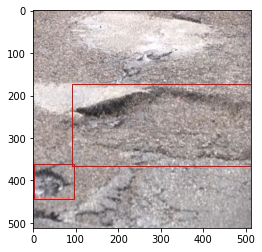

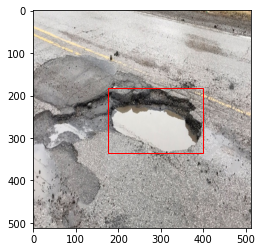

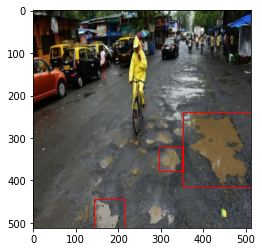

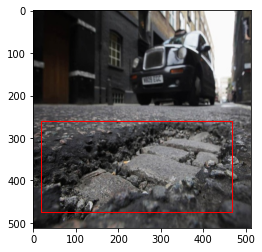

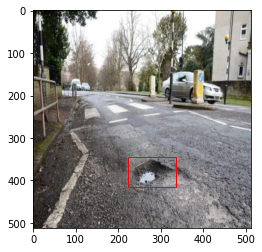

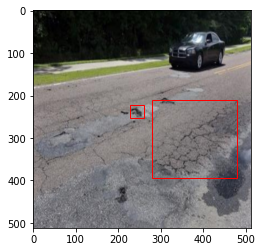

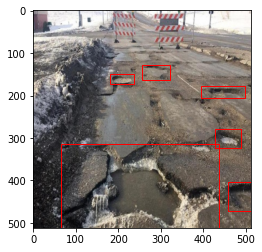

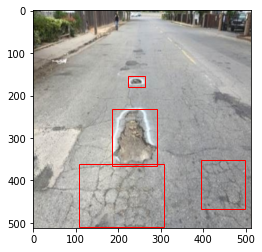

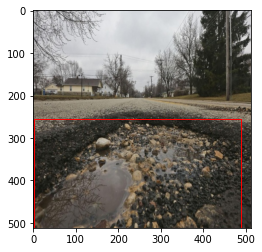

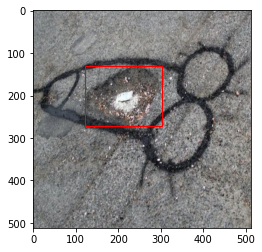

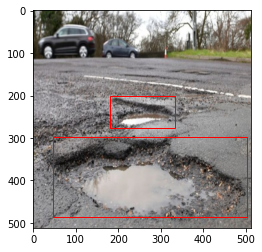

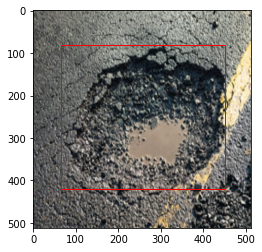

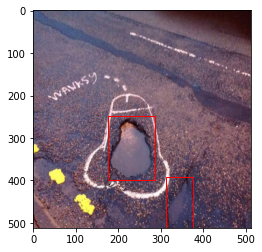

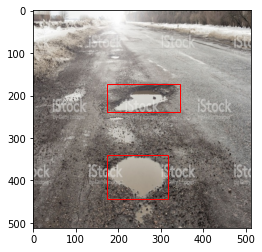

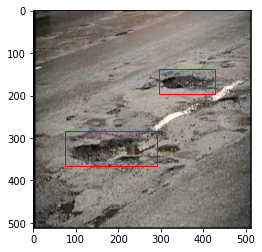

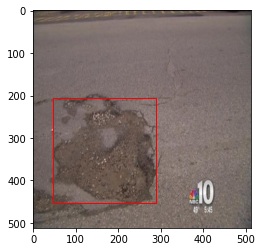

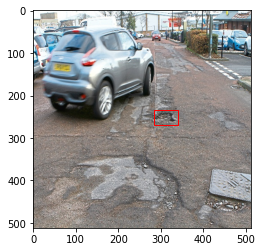

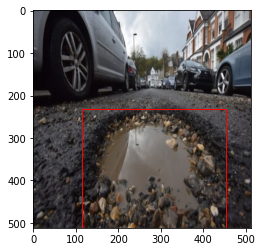

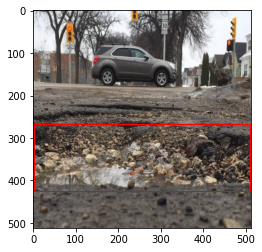

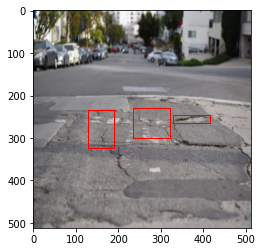

In [11]:
show_data(train, 20)

# Object Detection